# Machine Project 6: EDGAR Web Logs

In [114]:
# Add imports used throughout the project here
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import geopandas as gpd
import zipfile
import pandas as pd
import re
import edgar_utils
import graphviz
import pickle
from shapely.geometry import Point

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Group Part (75%)

For this portion of the machine project, you may collaborate with your group members in any way (including looking at group members' code). You may also seek help from CS 320 course staff (peer mentors, TAs, and the instructor). You **may not** seek or receive help from other CS 320 students (outside of your group) or anybody else outside of the course.

## Part 1: `server_log.zip` analysis

In [2]:
# Use pandas to read in "server_log.zip as a csv file"
server_log = pd.read_csv("server_log.zip",compression = 'zip')
server_log.head()

,ip,date,time,zone,cik,accession,extention,code,size,idx,norefer,noagent,find,crawler,browser
0,104.197.32.ihd,2017-01-01,00:00:00,0.0,1111711.0,0001193125-12-324016,-index.htm,200.0,7627.0,1.0,0.0,0.0,10.0,0.0,NaN
1,208.77.214.jeh,2017-01-01,00:00:00,0.0,789019.0,0001193125-06-031505,.txt,200.0,46327.0,0.0,0.0,0.0,10.0,0.0,NaN
2,54.197.228.dbe,2017-01-01,00:00:00,0.0,800166.0,0001279569-16-003038,-index.htm,200.0,16414.0,1.0,0.0,0.0,10.0,0.0,NaN
3,108.39.205.jga,2017-01-01,00:00:01,0.0,354950.0,0000950123-09-011236,-index.htm,200.0,8718.0,1.0,0.0,0.0,10.0,0.0,NaN
4,52.45.218.ihf,2017-01-01,00:00:01,0.0,1313918.0,0001209191-06-031555,.txt,200.0,8911.0,0.0,0.0,0.0,10.0,0.0,NaN


### Q1: What's the total size in bytes of the files requested?

Look at the `size` column of the CSV in `server_log.zip`.  We want to include duplicates here; this gives us an estimate of the amount of network traffic handled by EDGAR (since this data is only a sample, the true value will be even larger). Answer with an integer. 

**Note:** If you use `numpy` make sure to cast the final answer to an `int`.

In [3]:
#Q1
int(server_log['size'].sum())

24801002666

### Q2: How many filings have been accessed by the 10 IPs with the most accesses?

Answer with a dictionary, with the (anonymized) IP as key and the number of requests seen in the logs as the values. Each row in the logs corresponds to one request. Note that the anonymized IP addresses are consistent between requests.

**Hint:** for this question and most of the others expecting dictionary output, it might be easiest to use Pandas operations to process the data into a `Series` and to use the `to_dict()` method. Consider using tools like `groupby`, `apply`, and aggregation methods like `size()`. In Q30-32 from [MP1](../mp1/README.md), there is an example of `apply`.


In [4]:
#Q2
server_log['ip'].value_counts()[:10].to_dict()

{'54.152.17.ccg': 12562,
 '183.195.251.hah': 6524,
 '52.45.218.ihf': 5562,
 '68.180.231.abf': 5493,
 '204.212.175.bch': 4708,
 '103.238.106.gif': 4428,
 '208.77.215.jeh': 3903,
 '208.77.214.jeh': 3806,
 '217.174.255.dgd': 3551,
 '82.13.163.caf': 3527}

### Q3: What fraction of the requests had errors?

Any request with a status code greater than or equal to 400 has an error. Answer with a floating point number. 

**Note:** If you use `numpy` make sure to cast the final answer to a `float`.

In [5]:
#Q3
float((server_log['code']>=400).sum()/len(server_log))

0.03466852724527611

### Q4: What is the second most frequently accessed file?

Answer with a string formatted like so: "cik/accession/extention" (these are the names of columns in "rows.csv").

In [6]:
#Q4
server_log_q4 = server_log
server_log_q4['cik'] = server_log['cik'].astype(int)
server_log_q4['file_name'] = server_log_q4[['cik','accession','extention']].astype(str).agg('/'.join, axis=1)
server_log_q4['file_name'].value_counts().index[1]

'1584509/0001584509-16-000514/armk-20160930_def.xml'

## Part 2: Creating `edgar_utils.py` module

This part is to be started during [Lab 9](../../labs/Lab9/README.md). Finish the `edgar_utils.py` module now if you didn't have enough time
during the scheduled lab.

## Part 3: Using `edgar_utils.py` module

### Q5: Which region accesses resources most heavily in `server_log.zip`?

Use your `lookup_region` function and answer with a string.

In [7]:
#Q5
server_log['region'] = server_log['ip'].apply(edgar_utils.lookup_region)
server_log['region'].value_counts().idxmax()

'United States of America'

### Q6: What fraction of IPs in each region are high-volume users?

Consider IPs which accessed more than 300 EDGAR resoures to be
high-volume. This might indicate machines running automated scraping
and analysis tasks.

Note that given the sampling done in the data, the true EDGAR usage of
these machines is likely to be even heavier.

Answer with a dictionary, where the keys are the regions and the
values are the fraction (in floating point form) of IPs from that
region classified as high-volume.

**Example:**

Say "United States of America" has four IPs:
* 1.1.1.1 appears 1200 times in the logs
* 2.2.2.2 appears 900 times in the logs
* 3.3.3.3 appears 5 times in the logs
* 4.4.4.4 appears 234 times in the logs

This means that 1/2 of the IPs in the US are high volume, so there should be an entry like this:

```
{
    "United States of America": 0.5,
    ...
}
```

**Note:** Some of the filings are listed as having a region of '-'. Please include this in your final
answer.

**Note:** If you use `numpy` make sure to cast dictionary entries to `float`.

In [8]:
#Q6
regions = set(server_log['region'])
frac_hcol = {region:0 for region in regions}
for region in frac_hcol:
    ips_of_this_region = server_log[server_log['region']==region]['ip']
    frac_hcol_of_this_region = float((ips_of_this_region.value_counts()>300).mean())
    frac_hcol[region] = frac_hcol_of_this_region
frac_hcol

{'Thailand': 0.0,
 'Russian Federation': 0.0,
 'Saudi Arabia': 0.0,
 'Jordan': 0.0,
 'Australia': 0.07692307692307693,
 'Greece': 0.0,
 'Spain': 0.0,
 'France': 0.0036900369003690036,
 'Mongolia': 0.0,
 'Netherlands': 0.0,
 'Iraq': 0.0,
 'Cyprus': 0.0,
 'South Africa': 0.0,
 'Nigeria': 0.0,
 'Latvia': 0.0,
 'Estonia': 0.0,
 'India': 0.08823529411764706,
 'Brazil': 0.0,
 'China': 0.016018306636155607,
 'Japan': 0.0,
 'Finland': 0.0,
 'Ukraine': 0.0,
 'Slovenia': 0.0,
 'Poland': 0.0,
 'Jersey': 0.0,
 'Germany': 0.047619047619047616,
 'Italy': 0.0,
 'Lebanon': 0.0,
 'Angola': 0.0,
 'Malaysia': 0.0,
 'Bulgaria': 0.3333333333333333,
 'Hong Kong': 0.037037037037037035,
 'Canada': 0.05357142857142857,
 'Tanzania, United Republic of': 0.0,
 'Romania': 0.0,
 'Sudan': 0.0,
 'Taiwan (Province of China)': 0.0,
 'Austria': 0.0,
 'Croatia': 0.0,
 'Portugal': 0.0,
 'Denmark': 0.0,
 'Morocco': 0.0,
 'Sweden': 0.0,
 '-': 0.0,
 'Ireland': 0.625,
 'North Macedonia': 0.0,
 'Israel': 0.0,
 'Liberia': 0.0,


### Requirement: `filings` dictionary

Read every file ending with .htm or .html in `docs.zip`, and create a `Filing`
object based on that file. Then, save that `Filing` object to a dictionary as follows:
- **Key:** The filepath for this filing object (ex. `850693/0000850693-07-000159/-index.htm`)
- **Value:** The `Filing` object created from this filepath.

Creating this dictionary once now will save us from needing to loop over all values
in future questions.

In [9]:
# Create `filings` dictionary
filings = {}
with zipfile.ZipFile('docs.zip','r') as folder:
    for file in folder.namelist():
        if file.endswith(('html','htm')):
            with folder.open(file) as f:
                html_content = f.read().decode('utf-8') 
                filing_obj = edgar_utils.Filing(html_content)
                filings[file] = filing_obj

### Q7: What dates appear in the `886982/0000769993-16-001958/-index.htm` file of `docs.zip`?

Read the HTML from this file and use it to create a `Filing` object,
from which you can access the `.dates` attribute.

In [24]:
#Q7
filings['886982/0000769993-16-001958/-index.htm'].dates

['2016-12-30', '2016-12-30', '2016-12-20']

### Q8: What is the distribution of states for the filings in `docs.zip`?

Answer with a dict, like the following:

```
{'CA': 92,
 'NY': 83,
 'TX': 67,
 'None': 56,
 'MA': 30,
 'IL': 25,
 'PA': 25,
 'CO': 25,
 ...
}
```

The showing order of each key-value pair doesn't really matter. Please include `None` in the
dictionary.

**Hint:** We created the `filings` dictionary above, which means we don't have to
iterate through `docs.zip` here again!

In [42]:
#Q8
state_counts = {}
for filing in filings.values():  # filing is each Filing object
    states = filing.state() 
    # print(states) # returns a list of strings like ['IL 60606']
    if type(states) == str:
        if states not in state_counts:
            state_counts[states] = 1
        else:
            state_counts[states] += 1
    elif type(states) == list:
        for match in states:
            # print(match)
#         state_match = re.findall(r'[A-Z]{2}', match)
        # for state in state_match:
            if match not in state_counts:
                state_counts = 1
            else:
                state_counts[match] += 1
    else:
        if 'None' not in state_counts:
            state_counts['None'] = 0
        state_counts['None'] += 1
        
state_counts

{'CA': 92,
 'NJ': 23,
 'MS': 1,
 'MA': 30,
 'CO': 25,
 'NY': 83,
 'None': 56,
 'TX': 67,
 'FL': 21,
 'AL': 1,
 'IN': 5,
 'CT': 14,
 'UT': 5,
 'MD': 13,
 'KS': 5,
 'VA': 15,
 'OH': 10,
 'SD': 1,
 'DE': 9,
 'IL': 25,
 'GA': 9,
 'NC': 9,
 'PA': 25,
 'TN': 4,
 'MN': 15,
 'NM': 1,
 'KY': 2,
 'OK': 7,
 'AR': 1,
 'NV': 6,
 'VT': 1,
 'MO': 4,
 'MI': 11,
 'NE': 2,
 'IA': 6,
 'AZ': 5,
 'WI': 9,
 'LA': 2,
 'ID': 1,
 'OR': 2,
 'WV': 2,
 'WA': 3,
 'DC': 1,
 'ME': 1}

### Q9: What is the distribution for the ten most common addresses for the filings in `docs.zip`?

Answer in the same format as the previous question.

Expected output:
```
{'2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067': 134,
 '2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067\n3102014100': 113,
 '3 LANDMARK SQUARE\nSUITE 500\nSTAMFORD CT 06901\n2033564400': 60,
 'C/O KKR ASSET MANAGEMENT LLC\n555 CALIFORNIA STREET, 50TH FLOOR\nSAN FRANCISCO CA 94104': 36,
 'C/O ARES MANAGEMENT LLC\n2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067': 35,
 '4740 AGAR DRIVE\nRICHMOND A1 V7B 1A3': 25,
 'CENTRALIS S.A., 8-10 AVENUE DE LA GARE\nLUXEMBOURG N4 L-1610': 25,
 'CENTRALIS S.A., 8-10 AVENUE DE LA GARE\nLUXEMBOURG N4 L-1610\n352-26-186-1': 25,
 '3 LANDMARK SQUARE\nSUITE 500\nSTAMFORD CT 06901': 24,
 '801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102': 22}
```

In [12]:
#Q9
address_counts = {}

for ip in filings:
    for address in filings[ip].addresses:
        if address: # skip None or empty string
            if address not in address_counts:
                address_counts[address] = 1
            else:
                address_counts[address] += 1
dict(sorted(address_counts.items(),key = lambda item: item[1],reverse=True))

{'2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067': 134,
 '2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067\n3102014100': 113,
 '3 LANDMARK SQUARE\nSUITE 500\nSTAMFORD CT 06901\n2033564400': 60,
 'C/O KKR ASSET MANAGEMENT LLC\n555 CALIFORNIA STREET, 50TH FLOOR\nSAN FRANCISCO CA 94104': 36,
 'C/O ARES MANAGEMENT LLC\n2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067': 35,
 '4740 AGAR DRIVE\nRICHMOND A1 V7B 1A3': 25,
 'CENTRALIS S.A., 8-10 AVENUE DE LA GARE\nLUXEMBOURG N4 L-1610': 25,
 'CENTRALIS S.A., 8-10 AVENUE DE LA GARE\nLUXEMBOURG N4 L-1610\n352-26-186-1': 25,
 '3 LANDMARK SQUARE\nSUITE 500\nSTAMFORD CT 06901': 24,
 '801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102': 22,
 'C/O KKR ASSET MANAGEMENT LLC\n555 CALIFORNIA STREET, 50TH FLOOR\nSAN FRANCISCO CA 94104\n(415) 315-3620': 22,
 '2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067\n310-201-4100': 21,
 'CHC HOUSE, HOWE MOSS DRIVE\nKIRKHILL INDUSTRIAL ESTATE, DYCE\nABERDEEN, SCOTLAND X0 AB21 

# Individual Part (25%)

For this portion of the machine project, you are only allowed to seek help from CS 320 course staff (peer mentors, TAs, and the instructor). You **may not** receive help from anyone else.

## Part 4: Combining logs with documents

### Q10: What is the distribution of requests across industries?

For each request in the logs that has a corresponding filing in
`docs.zip`, lookup the SIC (ignore rows in the logs which refer to
pages not in `docs.zip`).

Answer with a dictionary, where the keys are the SIC and the values
are the number of times the resources of that industry were accessed.

If you're curious, consider looking up the industry names for the top
couple categories:
https://www.sec.gov/corpfin/division-of-corporation-finance-standard-industrial-classification-sic-code-list

Expected output:

```
{2834: 984,
 1389: 656,
 1311: 550,
 2836: 429,
 6022: 379,
 1000: 273,
 ...
 }
 ```

In [54]:
#Q10
# I need to find each log's corresponding filing first
# First thing to do is extract all log file names.
file_names = server_log['file_name']
# initiate sic count dictionary
sic_counts = {}
sic_counts['None'] = 0
# Now we should iterate through all log file names
for file_name in file_names:
    if file_name in filings:
        current_filing = filings[file_name]
        if current_filing.sic is None:
            sic_counts['None'] += 1
        elif current_filing.sic not in sic_counts:
            sic_counts[current_filing.sic] = 1
        else:
            sic_counts[current_filing.sic] += 1
dict(sorted(sic_counts.items(), key = lambda item : item[1],reverse = True))

{2834: 984,
 1389: 656,
 1311: 550,
 2836: 429,
 'None': 414,
 6022: 379,
 1000: 273,
 6211: 237,
 7371: 229,
 2860: 226,
 6021: 204,
 6282: 171,
 2510: 171,
 3825: 164,
 4841: 108,
 5621: 99,
 7200: 94,
 7374: 94,
 6331: 91,
 6798: 90,
 5311: 90,
 3842: 87,
 6221: 85,
 6029: 83,
 3272: 81,
 3829: 73,
 4931: 70,
 3510: 66,
 7830: 62,
 3826: 56,
 3695: 55,
 3620: 50,
 7373: 48,
 6799: 46,
 4412: 43,
 4512: 42,
 7340: 40,
 7370: 39,
 900: 39,
 6513: 38,
 3621: 38,
 5172: 36,
 5900: 35,
 4213: 35,
 3990: 34,
 5122: 34,
 5944: 33,
 2070: 33,
 8090: 32,
 1700: 31,
 3312: 31,
 1381: 31,
 4922: 31,
 6324: 30,
 8742: 27,
 7389: 26,
 8731: 25,
 7812: 25,
 3590: 24,
 4955: 23,
 3663: 23,
 4522: 22,
 6321: 21,
 3559: 20,
 5812: 19,
 6792: 19,
 6189: 18,
 7372: 16,
 3841: 14,
 6199: 11,
 1731: 11,
 4911: 8,
 4833: 7,
 6035: 7,
 3571: 6,
 2430: 6,
 3679: 5,
 3674: 5,
 4813: 4,
 3678: 4,
 4812: 4,
 1531: 4,
 5500: 4,
 6411: 3,
 1400: 3,
 2800: 3,
 3420: 3,
 8062: 3,
 3576: 3,
 2870: 2,
 1040: 2,
 87


### Q11: How many requests were made in each hour?

Use `pd.to_datetime` (the `hour` attributes of the converted
timestamps may be useful) or string manipulation to process the `time`
column. Answer with a dictionary, where the keys are integers from 0
to 23 representing the hour of the day, and the values are the number
of requests made in that hour.

In [ ]:
server_log['time']

In [55]:
#Q11
hour = dict(pd.to_datetime(server_log['time']).dt.hour.value_counts())
hour = {key:int(value) for key, value in hour.items()} # change value's data type to integer
dict(sorted(hour.items(),key= lambda i:i[0]))

/tmp/ipykernel_743668/3948067961.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hour = dict(pd.to_datetime(server_log['time']).dt.hour.value_counts())


{0: 8305,
 1: 8242,
 2: 8550,
 3: 8850,
 4: 8343,
 5: 9783,
 6: 7761,
 7: 8213,
 8: 8292,
 9: 11033,
 10: 6377,
 11: 6435,
 12: 6155,
 13: 6006,
 14: 6654,
 15: 6512,
 16: 5680,
 17: 6487,
 18: 6356,
 19: 6211,
 20: 6066,
 21: 6164,
 22: 6098,
 23: 6283}

### Q12: What is the geographic overlap in interest between Australia, France, Indonesia, and Viet Nam?

Answer with a Digraph like the following:

<img src="img/digraph.png" width=400>

In addition to a node for each of these three countries, there should
be a node for each state having a filing accessed by somebody in one
of these countries.

An edge from a country to a state means somebody in that country
looked at least one filing for a company in that state.

**Important:** Make sure not to hardcode these values. It might be helpful to
define a list like `countries = ["Australia", "France", "Indonesia", "Viet Nam"]` and then loop over the filings for these countries only.

In [81]:
AFIV_log = server_log[server_log['region'].isin(["Australia", "France", "Indonesia", "Viet Nam"])]
AFIV_log

,ip,date,time,zone,cik,accession,extention,code,size,idx,norefer,noagent,find,crawler,browser,file_name,region
181,178.255.215.edc,2017-01-01,00:00:55,0.0,846030,0000846030-96-000027,-index.htm,301.0,603.0,1.0,0.0,0.0,10.0,0.0,NaN,846030/0000846030-96-000027/-index.htm,France
269,163.172.66.gee,2017-01-01,00:01:22,0.0,1409287,0000029332-11-000025,.txt,301.0,626.0,0.0,0.0,0.0,10.0,0.0,NaN,1409287/0000029332-11-000025/.txt,France
357,163.172.65.bhg,2017-01-01,00:01:51,0.0,320193,0001181431-12-024430,xslF345X01/rrd342238.xml,301.0,636.0,0.0,0.0,0.0,10.0,0.0,NaN,320193/0001181431-12-024430/xslF345X01/rrd3422...,France
653,130.194.60.cje,2017-01-01,00:03:38,0.0,860749,0000891618-02-005061,.txt,200.0,231067.0,0.0,0.0,0.0,10.0,0.0,NaN,860749/0000891618-02-005061/.txt,Australia
915,130.194.60.cje,2017-01-01,00:05:22,0.0,881524,0000891618-96-002857,.txt,200.0,14669.0,0.0,0.0,0.0,10.0,0.0,NaN,881524/0000891618-96-002857/.txt,Australia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173859,130.194.60.cje,2017-01-01,23:50:19,0.0,29924,0000029924-01-500023,.txt,200.0,539915.0,0.0,0.0,0.0,10.0,0.0,NaN,29924/0000029924-01-500023/.txt,Australia
173884,130.194.60.cje,2017-01-01,23:50:34,0.0,29924,0000029924-06-000176,.txt,200.0,752735.0,0.0,0.0,0.0,10.0,0.0,NaN,29924/0000029924-06-000176/.txt,Australia
174353,130.194.60.cje,2017-01-01,23:55:15,0.0,866121,0001104659-10-057198,.txt,200.0,5973781.0,0.0,0.0,0.0,10.0,0.0,NaN,866121/0001104659-10-057198/.txt,Australia
174642,130.194.60.cje,2017-01-01,23:57:47,0.0,732712,0001193125-08-095227,.txt,301.0,598.0,0.0,0.0,0.0,10.0,0.0,NaN,732712/0001193125-08-095227/.txt,Australia


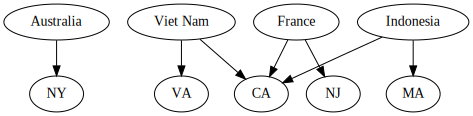

In [87]:
#Q12
d = graphviz.Digraph()
countries = ["Australia", "Indonesia", "Viet Nam","France"]
# ADD CODE HERE
AIVF_log = server_log[server_log['region'].isin(countries)]
for country in countries:
    d.node(country)

# prepare a list to contain groups of country and state; it will be transformed to set later.
coutry_state_tuples = []

# iterate through every row in AIVF_log
for _, log in AIVF_log.iterrows():
    current_file_name = log['file_name']
    current_country = log['region']
    
    if current_file_name in filings:
        current_filing = filings[current_file_name]
        coutry_state_tuples.append((current_country, current_filing.state()))

coutry_state_tuples = set(coutry_state_tuples)
for t in coutry_state_tuples:
    d.edge(t[0],t[1])
        # IMPORTANT -- Do not remove -- 
with open("Q12.pkl", "wb") as f:
    pickle.dump(d.source, f)
d

### Q13: Geographic plotting of postal code

The `locations.geojson` contains the positions of some of the
addresses in the dataset.  Plot this over the background map in
"shapes/cb_2018_us_state_20m.shp"

Additional requirements:

* **Important:** Make sure to pass in `ax` as an argument when plotting: `.plot(ax=ax, ...)`
* Use the given lat/lon to crop the bounds:
* Use a Mercator projection, "epsg:2022"
* The color of each point should indicate the postal code. For example, the postal code of `245 SUMMER STREET\nBOSTON MA 02210` is `2210`. If it's in the form like `53705-1234`, only take `53705`. If it's neither 5 digits number nor 9 digits number, don't use the point.
* Only show the street with a postal code from 10000 to 60000
* Use the "viridis" colormap, with a colorbar
* The color of background is "lightgray"

The result should look similar to this:

<img src="img/geo.png" width="400px">

**Hint:** If you are getting issues with getting the slanted lines or issues with your graphs 
disappearing, make sure that you are applying the `.to_crs(...)` function to both the points
and the background before plotting.

In [117]:
west = -90
east = -65
north = 50
south = 25

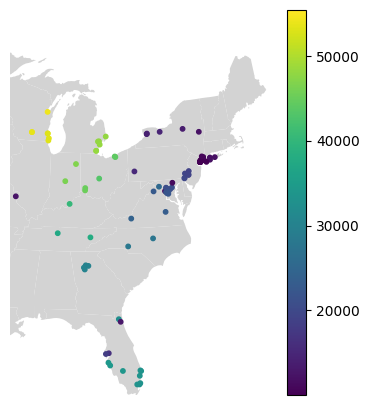

In [122]:
#Q13

# ADD CODE HERE
background = gpd.read_file("shapes/cb_2018_us_state_20m.shp")
locations = gpd.read_file("locations.geojson")
locations = locations.set_index("address")


def extract_zipcode(address):
    match = re.findall(r'\b(\d{5})\b', address)
    if match:
        zip_int = int(match[0])
        if 10000 <= zip_int <= 60000:
            return zip_int
    return None

locations['zipcode'] = locations.index.to_series().apply(extract_zipcode)

background = background.to_crs(epsg=2022)
locations = locations.to_crs(epsg=2022)

bounds_df = gpd.GeoDataFrame(geometry=[
    Point(west, south),  # southwest
    Point(east, north)   # northeast
], crs='EPSG:4326').to_crs(epsg=2022)

min_x, min_y = bounds_df.geometry[0].x, bounds_df.geometry[0].y
max_x, max_y = bounds_df.geometry[1].x, bounds_df.geometry[1].y

locations.head()

# Create the plot
fig, ax = plt.subplots(figsize = (5,5))

# PLOT HERE
background.plot(ax=ax, color="lightgray")
locations.plot(ax=ax,column="zipcode", cmap="viridis", legend=True, markersize=10)

ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
plt.axis("off")
# IMPORTANT -- Do not remove -- 
with open("Q13.pkl", "wb") as f:
    pickle.dump(fig, f)

plt.show()